# Milestone 6

In this milestone, we implement some of the extensions mentioned in Milestone 5.

## Recall of previous work

Please refer to the [Milestone 4 Report](https://github.com/ML4BD/milestone-4-roguesgallery/blob/master/reports/Milestone%204%20Report.pdf) and the [Milestone 4 Notebook](https://github.com/ML4BD/milestone-4-roguesgallery/blob/master/notebooks/Milestone04/m4_lernnavi_roguesgallery.ipynb) for more details.

---

In Milestone 4, our objective was to predict the level check success of students with respect to their behavior on the **Lernnavi** learning platform. 

To this end, we **pre-processed** the data by removing students identified as inactive using criteria such as least number of actions per week. Then we selected a subset of features for each student and transformed their data into time series.<br>
In an attempt to see if **regularity** helped categorize students into subgroups, we followed the procedure of [Shirvani Boroujeni, et al](https://infoscience.epfl.ch/record/218657/files/) to compute regularity features on online learning time series. We then clustered the students using the regularity metrics.<br>
Finally, we trained multiple time series **classifiers** to predict wether a student would pass a level check or not. One classifier was trained per cluster and one over the whole data. We used 2 different classification techniques.

## Implementations of this milestone

For this milestone, we are planning on taking another approach to solving our research question. Indeed, in the first milestone, we demonstrated the **predictive potential of a user's behavior time series** for its **success in level checks**. For this, we clustered with respect to time-agnostic metrics and then classified the time series.

Our second approach will be to cluster with respect to user time series and then classify using features derived from theuser's engagement, inspired from [Hussain et al.](https://www.hindawi.com/journals/cin/2018/6347186/).

To this end, we will proceed as follows:

1. Separate math and german-related actions in the data.

2. Cluster the user's behaviors using time series clustering.

3. Compute the engagement features.

4. Train a decision tree classifier on our created features.


In [209]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
from functools import reduce
from itertools import product
import pickle
import warnings

from tslearn.clustering import KernelKMeans, KShape, TimeSeriesKMeans
from tslearn.clustering import silhouette_score as ts_silhouette_score
from tslearn.utils import to_time_series_dataset

from sklearn.model_selection import GridSearchCV

In [179]:
# Config
tqdm.pandas()
warnings.filterwarnings('ignore') # set to 'ignore' or 'default'

In [8]:
# variables
DATA_DIR = '../../data/'

## Data Processing

### Splitting between Math and German

#### Data Loading

In [46]:
# Loading events & transactions merged & cleaned
path_suffix = "interim/"
filename = 'events_transac_MERGED.csv.gz'
data = pd.read_csv(DATA_DIR + path_suffix + filename)

# Visualizing first rows
print(f"###### Visualizing {filename}:")
print(f"Columns:\n{list(data.columns)}")
print()

data.head(3)

###### Visualizing events_transac_MERGED.csv.gz:
Columns:
['transaction_id', 'transaction_token', 'user_id', 'document_id', 'document_version', 'evaluation', 'input', 'start_time', 'commit_time', 'user_agent', 'validation', 'solution', 'type', 'learn_session_id', 'topic_id', 'is_closed', 'type_id', 'is_accepted', 'num_checks', 'event_id', 'timestamp', 'category', 'action', 'event_type', 'session_id', 'tracking_data', 'num_participations', 'week', 'num_actions_per_week', 'num_weeks_per_user']



,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week,num_weeks_per_user
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,2022-02-18 15:13:38.387,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,2022-02-18 15:13:40.545,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7,6
2,1576012,379dad17-2d6f-42f3-b6f0-68a39664733b,387604.0,1taQDeFXg1E9GxbT0YApJU,115407,NaN,NaN,1645197222948,NaN,unknown,...,2022-02-18 15:13:43.057,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6


In [47]:
# Loading table containing Math / German information
path_suffix = 'raw/'
filename = 'topics_translated.csv.gz'
topics_translated = pd.read_csv(DATA_DIR + path_suffix + filename)

# Visualizing first rows
print(f"###### Visualizing {filename}:")
print(f"Columns:\n{list(topics_translated.columns)}")
print()

topics_translated.head(3)

###### Visualizing topics_translated.csv.gz:
Columns:
['id', 'name', 'description', 'name_english', 'description_english', 'math']



,id,name,description,name_english,description_english,math
0,1,Deutsch,Sprache als System,German,Language as a system,0.0
1,2,Orthografie,NaN,spelling,NaN,0.0
2,3,Rechtschreibprinzipien,NaN,Spelling principles,NaN,0.0


#### Events categorization

In [48]:
# Keeping only relevant columns
topics_translated = topics_translated[['id', 'math']]
topics_translated.sample(3)

,id,math
462,3314,0.0
301,3069,0.0
20,966,1.0


In [49]:
# Merging MATH/GERMAN info into data table
print(f"Size of 'data' DF before merge: {data.shape[0]:,} lines")

# merging
data_categorized = data.merge(topics_translated, left_on='topic_id', right_on='id', how='inner')

print(f"Size of 'data' DF after merge: {data_categorized.shape[0]:,} lines")
data_categorized.iloc[0]

# You can observe the additional info 'id' & 'math' at the end of the first line's columns

Size of 'data' DF before merge: 790,425 lines
Size of 'data' DF after merge: 790,425 lines


transaction_id                                       1576010
transaction_token       a65959df-7bf0-4956-9aa7-511af281fdb5
user_id                                             387604.0
document_id                           18FedrGurdA7jklbk0mtVA
document_version                                      115404
evaluation                                               NaN
input                                                    NaN
start_time                                     1645197218251
commit_time                                  1645197220536.0
user_agent                                           unknown
validation                                              SKIP
solution                                                 NaN
type                                                     NaN
learn_session_id                                      111059
topic_id                                                3250
is_closed                                                  0
type_id                 

In [50]:
# Removing the 'id' duplicate feature
data_categorized.drop(columns='id', inplace=True)

In [51]:
# Splitting between german and math
print(f"Size before split: {data_categorized.shape[0]:,} lines")
print()

df_german = data_categorized.loc[data_categorized.math == 0.0].drop(columns='math')
df_math = data_categorized.loc[data_categorized.math == 1.0].drop(columns='math')

print(f"Size of german split: {df_german.shape[0]:,} lines")
print(f"Size of math split: {df_math.shape[0]:,} lines")

# Verificiation
assert(df_german.shape[0] + df_math.shape[0] == data_categorized.shape[0]), "Some lines were lost in the splits!"

Size before split: 790,425 lines

Size of german split: 634,807 lines
Size of math split: 155,618 lines


In [52]:
## Saving split data

# Creating folder if non existent
folder = 'MATH_GERMAN_split/'
path = DATA_DIR + 'processed/'+folder

if folder.split('/')[0] not in os.listdir(DATA_DIR + 'processed/'):
    os.mkdir(path)
    
# Saving data
filename = 'events_transac_GERMAN.csv.gz'
_check = input(f'Are you sure that you want to save {filename} in {path}?\n[yes|no]')
if _check == "yes":
    df_german.to_csv(path+filename)
    
filename = 'events_transac_MATH.csv.gz'
_check = input(f'Are you sure that you want to save {filename} in {path}?\n[yes|no]')
if _check == "yes":
    df_math.to_csv(path+filename)

Are you sure that you want to save events_transac_GERMAN.csv.gz in ../../data/processed/MATH_GERMAN_split/?
[yes|no] no
Are you sure that you want to save events_transac_MATH.csv.gz in ../../data/processed/MATH_GERMAN_split/?
[yes|no] no


In [53]:
# Freeing up RAM
del data
del data_categorized
del topics_translated

### Creating user time series for both German and Math

#### Data loading

In [55]:
# Loading German and math data
folder = 'MATH_GERMAN_split/'
path = DATA_DIR + 'processed/'+folder

filename = 'events_transac_GERMAN.csv.gz'
df_german = pd.read_csv(path + filename, index_col=0)

filename = 'events_transac_MATH.csv.gz'
df_math = pd.read_csv(path + filename, index_col=0)

print("NOTE: Both dataframes look the same. The difference is that the first one is German and the second one is Math.")
print()
print(f"Columns: \n{list(df_math.columns)}")
df_math.head(3)

NOTE: Both dataframes look the same. The difference is that the first one is German and the second one is Math.

Columns: 
['transaction_id', 'transaction_token', 'user_id', 'document_id', 'document_version', 'evaluation', 'input', 'start_time', 'commit_time', 'user_agent', 'validation', 'solution', 'type', 'learn_session_id', 'topic_id', 'is_closed', 'type_id', 'is_accepted', 'num_checks', 'event_id', 'timestamp', 'category', 'action', 'event_type', 'session_id', 'tracking_data', 'num_participations', 'week', 'num_actions_per_week', 'num_weeks_per_user']


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week,num_weeks_per_user
265833,729269,d471b18d-8aec-45e8-a92e-6a2405ad700f,387604.0,7jtbzlKxycH6cW4AluHWvW,80848,NaN,NaN,1625213473122,1.625217e+12,unknown,...,2021-07-02 08:11:13.272,TASK,VIEW_QUESTION,VIEW,37243.0,NaN,5,6,16,6
265834,729269,d471b18d-8aec-45e8-a92e-6a2405ad700f,387604.0,7jtbzlKxycH6cW4AluHWvW,80848,NaN,NaN,1625213473122,1.625217e+12,unknown,...,2021-07-02 09:11:02.900,TASK,VIEW_QUESTION,VIEW,37243.0,NaN,5,6,16,6
265835,729269,d471b18d-8aec-45e8-a92e-6a2405ad700f,387604.0,7jtbzlKxycH6cW4AluHWvW,80848,NaN,NaN,1625213473122,1.625217e+12,unknown,...,2021-07-02 09:11:06.952,SESSION,SKIP,CLICK,37243.0,NaN,5,6,16,6


#### Utils

In [58]:
def build_time_ref(df_features):
    """
    Creates a simple DataFrame with a single column enumerating the weeks from the minimum 
    up to the maximum week number observed in the data.
    """
    min_week = df_features.week.min()
    max_week = df_features.week.max()
    time_ref = pd.DataFrame(range(min_week, max_week)).rename(columns = {0:'week'})
    return time_ref

def build_actions_ref(df_features, time_ref = None):
    """
    Creates a DataFrame filled with NaN with one column for the week enumeration and one for
    each of the actions detected in df_features.
    """
    if time_ref is None : time_ref = build_time_ref(df_features)
    
    actions_ref = df_features.action.unique()
    actions_ref = pd.DataFrame(columns=actions_ref, index=time_ref.index).reset_index().rename(columns={'index':'week'})
    return actions_ref

In [59]:
def build_num_actions_per_week(df_features, u, time_ref=None, _fill=0.0):
    """
    Gets and formats the 'num_actions_per_week' information from the input table for the specified user u.
    The result contains one line per week of the time series. NaNs are replaces with the _fill value.
    """
    if time_ref is None: time_ref = build_time_ref(df_features)
    
    # Getting info
    num_actions_per_week = df_features.loc[df_features.user_id == u, ['week', 'num_actions_per_week']].drop_duplicates(['week', 'num_actions_per_week'])
    # Filling the gaps in weeks to form time series
    num_actions_per_week = num_actions_per_week.merge(time_ref, on='week', how='right').fillna(_fill)
    return num_actions_per_week

In [60]:
def build_one_hot_actions(df_features, u, actions_ref=None, time_ref=None, _fill=0.0):
    """
    Fills in the action_ref template with the count of the action for the designated week, for the specified user u.
    NaNs are filled with the _fill value.
    """
    if time_ref is None: time_ref = build_time_ref(df_features)
    if actions_ref is None: actions_ref = build_actions_ref(df_features)
    
    # Store the unique actions' dataframes.
    actions = []

    for c in actions_ref.columns[1:]:
        # Getting the count for each action for each week
        one_hot_action = df_features.loc[(df_features.user_id == u) & (df_features.action == c), ['week']].reset_index().groupby(['week']).count().reset_index().rename(columns={'index':c})
        # Merging to account for all weeks
        one_hot_action = one_hot_action.merge(time_ref, how='right', on='week').fillna(_fill)

        actions.append(one_hot_action)

    one_hot_actions = reduce(lambda left, right : left.merge(right, how='outer', on='week') , actions)
    
    return one_hot_actions


In [64]:
def build_elapsed_time(df_features, u, average=np.mean, time_ref = None, _fill=0.0):
    """
    Builds the elapsed time feature accounting for the average time spent on actions each week.
    Actions are not distinguished. Only actions with a `commit_time` value are taken into account.
    NaNs are filled with the _fill value.
    """
    # Extracts the valid data (non NaN commit_time)
    elapsed_time = df_features.loc[(df_features.user_id == u) & (~df_features.commit_time.isna()), ['week', 'start_time', 'commit_time']]
    # Compute elasped time values
    elapsed_time['elapsed_time'] = elapsed_time.commit_time - elapsed_time.start_time

    # Compute the average of these values
    elapsed_time = elapsed_time.groupby('week').agg(average).reset_index()[['week', 'elapsed_time']]
    # Formats to time serie & fills NaNs
    elapsed_time = elapsed_time.merge(time_ref, on='week', how='right').fillna(0.0)
    
    return elapsed_time

In [65]:
def aggregate_level_check_scores(r, threshold = 0.5) :
    """
    Aggregates the level checks for multiple level checks in a single week for a single user.
    """
    pass_ratio = sum(r) / len(r)
    return pass_ratio > threshold

In [66]:
def create_week_number(d):
    return (d.isocalendar()[0]-2021)*53 + d.isocalendar()[1]-1

In [74]:
def to_time_series(df_features, time_ref, actions_ref):
    """
    Builds complete time series tracking for each week the number of times an action was performed and fills all weeks for all users.
    Output is a list of DF, one per user.
    """
    users = df_features.user_id.unique()
    X = []
    
    for u in tqdm(users):
        # Building the num actions per week 
        num_actions_per_week = build_num_actions_per_week(df_features, u, time_ref=time_ref)

        # Building the one hot encoding of actions
        one_hot_actions = build_one_hot_actions(df_features, u, actions_ref=actions_ref, time_ref=time_ref)

        # Computing the average time spent on an action per week 
        elapsed_time = build_elapsed_time(df_features, u, average=np.mean, time_ref=time_ref)

        # Aggregate all into final feature vector
        _all = [num_actions_per_week, elapsed_time, one_hot_actions]
        _X = reduce(lambda left, right : left.merge(right, how='outer', on='week') , _all).set_index('week')

        X.append((u, _X))
        
    return X

#### Time Series feature creation

In [75]:
# Keeping only the relevant columns for both dataframes
relevant_columns = ['user_id', 'timestamp', 'week', 'category', 'action', 'start_time', 'commit_time', 'num_checks', 'num_participations', 'num_actions_per_week', 'num_weeks_per_user']

df_german = df_german[relevant_columns]
df_math = df_math[relevant_columns]

In [76]:
# Building time and actions reference DFs
# NOTE: They do not depend on the dataframe (i.e. we have all weeks and all actions represented in both)
time_ref = build_time_ref(df_math)
actions_ref = build_actions_ref(df_math)

In [83]:
# Creating the time features
time_series_german = to_time_series(df_math, time_ref, actions_ref)
time_series_math = to_time_series(df_german, time_ref, actions_ref)

100%|██████████████████████████████████████████████████████████████| 2124/2124 [22:36<00:00,  1.57it/s]


In [93]:
# Visualize results
print("##### GERMAN")
print(f"Number of user time series (unique users): {len(time_series_german):,} ")
print(f"Number of time steps in one time series: {time_series_german[0][1].shape[0]:,}")
print(f"Number of columns per time series: {time_series_german[0][1].shape[1]:,}")
print(f"Columns: {list(time_series_german[0][1].columns)}")

print("\n##### MATH")
print(f"Number of user time series (unique users): {len(time_series_math):,} ")
print(f"Number of time steps in one time series: {time_series_math[0][1].shape[0]:,}")
print(f"Number of columns per time series: {time_series_math[0][1].shape[1]:,}")
print(f"Columns: {list(time_series_math[0][1].columns)}")

##### GERMAN
Number of user time series (unique users): 1,374 
Number of time steps in one time series: 41
Number of columns per time series: 14
Columns: ['num_actions_per_week', 'elapsed_time', 'VIEW_QUESTION', 'SKIP', 'REVIEW_TASK', 'SUBMIT_ANSWER', 'NEXT', 'OPEN_FEEDBACK', 'CLOSE_FEEDBACK', 'CLOSE', 'GO_TO_THEORY', 'GO_TO_COMMENTS', 'GO_TO_BUG_REPORT', 'SHARE']

##### MATH
Number of user time series (unique users): 2,124 
Number of time steps in one time series: 41
Number of columns per time series: 14
Columns: ['num_actions_per_week', 'elapsed_time', 'VIEW_QUESTION', 'SKIP', 'REVIEW_TASK', 'SUBMIT_ANSWER', 'NEXT', 'OPEN_FEEDBACK', 'CLOSE_FEEDBACK', 'CLOSE', 'GO_TO_THEORY', 'GO_TO_COMMENTS', 'GO_TO_BUG_REPORT', 'SHARE']


<span style='color:red'>**Note**</span>

Let us note here that the german set contains 634'807 lines and the math set contains 155'618 lines. Therefore, we have approximately **4.5** times more events/transactions in the german set than in the math sets. <br>
However, we see here that the number of unique users is 2'124 for math and 1'374 for german. Thus this time we have around **2** times more users in the math set than in the german set.<br>
**We conclude that student studying German go more often on the platform than those studying Math, even if there are less of them.**

In [95]:
# Creating folder if non existent
folder = 'MATH_GERMAN_split/'
path = DATA_DIR + 'processed/'+folder

if folder.split('/')[0] not in os.listdir(DATA_DIR + 'processed/'):
    os.mkdir(path)
    
# Saving data
filename = 'time_series_GERMAN.pickle'
_check = input(f'Are you sure that you want to save {filename} in {path}?\n[yes|no]')
if _check == "yes":
    with open(path + filename, "wb") as f:
        pickle.dump(time_series_german, f)
        
filename = 'time_series_MATH.pickle'
_check = input(f'Are you sure that you want to save {filename} in {path}?\n[yes|no]')
if _check == "yes":
    with open(path + filename, "wb") as f:
        pickle.dump(time_series_math, f)

Are you sure that you want to save time_series_GERMAN.pickle in ../../data/processed/MATH_GERMAN_split/?
[yes|no] yes
Are you sure that you want to save time_series_MATH.pickle in ../../data/processed/MATH_GERMAN_split/?
[yes|no] yes


In [96]:
# Freeing space
del df_german
del df_math
del time_series_german
del time_series_math

## Time Series Clustering

We are using the [ts learn library](https://tslearn.readthedocs.io/en/stable/gen_modules/tslearn.clustering.html#module-tslearn.clustering) to cluster our time series datasets.<br>
Namely, the library offers 3 types of clustering techniques:
- `TimeSeriesKMeans`: an adaption of the KMeans algorithms to time series,
- `KernelKMeans`: applies a kernel function to the data before performing KMeans,
- ~~`KShape`: a clustering algorithm for time series developed by [Paparrizos et al.](http://www1.cs.columbia.edu/~jopa/Papers/PaparrizosSIGMOD2015.pdf)~~ *Due to time constraints*

### Data Loading

In [155]:
# Loading up the time series
folder = 'MATH_GERMAN_split/'
path = DATA_DIR + 'processed/'+folder

filename = 'time_series_GERMAN.pickle'
with open(path + filename, "rb") as f:
        time_series_german = pickle.load(f)
        

filename = 'time_series_MATH.pickle'
with open(path + filename, "rb") as f:
        time_series_math = pickle.load(f)

In [156]:
# Accessing the first user's data
print("user_id:")
display(time_series_german[0][0])
print("time series data:")
time_series_german[0][1].head(3)

user_id:


387604.0

time series data:


,num_actions_per_week,elapsed_time,VIEW_QUESTION,SKIP,REVIEW_TASK,SUBMIT_ANSWER,NEXT,OPEN_FEEDBACK,CLOSE_FEEDBACK,CLOSE,GO_TO_THEORY,GO_TO_COMMENTS,GO_TO_BUG_REPORT,SHARE
week,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Utils

In [181]:
def gridsearch_clustering(model_class, params, data, scoring_func=ts_silhouette_score):
    """
    Performs a gridsearch for the clustering technique with the input dict of params.
    """
    # Creating all combinations of parameters
    combinations = list(product(*list(params.values())))
    
    print(f"Performing {len(combinations)} iterations in total.")
    
    results = []
    
    for c in tqdm(combinations):
        # linking values to param name
        _params = dict(zip(params.keys(), c))
        print(f"Running {_params}")
        
        # Clustering
        model = model_class(**_params)
        labels = model.fit_predict(data)
        
        if 'metric' in params.keys(): metric = _params['metric']
        else: metric=None
        
        score = ts_silhouette_score(data, labels, metric=metric)
        print(f"Score: {score}")
        
        results.append((_params, score))
        
    return results

In [296]:
def _create_labels(params, hue):
    """
    Creates the set of labels for the input param values.
    """
    params = params.copy()
    params.pop(hue)
    labels = [str(params[k]) + '\n' for k in params.keys()]
    labels = "".join(labels)
    return labels

def plot_results(results, hue='metric'):
    """
    Expects a dict with various params and a score result.
    """
    hue_values = np.unique([p[hue] for p, _ in results])
    assert(len(hue_values)>=2), "The indicated hue parameter features less than 2 values!"
    
    # Separate set based on hue
    sets = [
        [(p, s) for (p, s) in results if p[hue]==h] for h in hue_values
    ]

    # Get y and x
    ys = [
        [s for _,s in _set] for _set in sets
    ]
    xs = [
        [p for p,_ in _set] for _set in sets
    ]
    xlabels = [
        [_create_labels(p, hue) for p in x_set] for x_set in xs
    ]
    
    assert(all([a==b for a,b in zip(xlabels[0], xlabels[1])])), "There are different configurations for both hue params."

    _adjust = "\n" * len(xs[0][0].keys())
    xlabels = [_adjust+l if i%2==1 else l for i, l in enumerate(xlabels[0])]
    
    plt.figure(figsize=(15,5))
    lines = [plt.plot(_y)[0] for _y in ys]
    plt.grid()
    plt.legend(lines, hue_values)
    plt.xticks(ticks=list(range(len(ys[0]))), labels=xlabels)
    plt.show()

### Clustering

In [173]:
# Converting both to time series
time_series_dataset_german = [df.values for _, df in time_series_german]
time_series_dataset_german = to_time_series_dataset(time_series_dataset_german)

time_series_dataset_math = [df.values for _, df in time_series_math]
time_series_dataset_math = to_time_series_dataset(time_series_dataset_math)

#### TimeSeriesKMeans

Model parameters to grid-search:
- `n_clusters`: number of clusters,
- `max_iter`: maximum number of iterations,
- `tol`: tolerance criterion for the difference in inertia between 2 iterations,
- `metric`: similarity metric to use,
- `dtw_inertia`: wether to user DTW inertia (even if DTW is not the selected metric)

In [251]:
# Safekeep 
_check = input("!!! We paused you here in case you are reexecuting the whole notebook. Are you certain that you want to run the next cell again?\n(Your answer does not matter. Please stop the execution now if you do not want the next cell to run.)")

!!! We paused you here in case you are reexecuting the whole notebook. Are you certain that you want to run the next cell again?
(Your answer does not matter. Please stop the execution now if you do not want the next cell to run.) okok


In [183]:
params = {
    'n_clusters':[2, 3, 4, 5, 6],
    'max_iter':[50, 100],
    'tol':[1e-5, 1e-6, 1e-7],
    'metric':['euclidean', 'dtw'], # 'softdtw' causes NaN error ?!
    'dtw_inertia':[True, False]
}

print("Runnning German...")
results_german = gridsearch_clustering(TimeSeriesKMeans, params, time_series_dataset_german)
print("\nRunning Math...")
results_math = gridsearch_clustering(TimeSeriesKMeans, params, time_series_dataset_math)

Runnning German...
Performing 120 iterations in total.


  0%|                                                                          | 0/120 [00:00<?, ?it/s]

Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


  1%|▌                                                                 | 1/120 [00:02<04:09,  2.10s/it]

Score: 0.986604170775415
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


  2%|█                                                                 | 2/120 [00:03<02:53,  1.47s/it]

Score: 0.986604170775415
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


  2%|█▌                                                              | 3/120 [03:27<3:03:55, 94.32s/it]

Score: 0.9798210393910655
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


  3%|██                                                             | 4/120 [07:03<4:34:50, 142.16s/it]

Score: 0.9798210393910655
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


  4%|██▋                                                             | 5/120 [07:06<2:56:06, 91.88s/it]

Score: 0.9741145494058404
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


  5%|███▏                                                            | 6/120 [07:07<1:55:58, 61.04s/it]

Score: 0.9839782223085299
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


  6%|███▋                                                           | 7/120 [10:49<3:34:11, 113.73s/it]

Score: 0.9798210393910655
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


  7%|████▏                                                          | 8/120 [14:29<4:35:17, 147.48s/it]

Score: 0.9798210393910655
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


  8%|████▋                                                          | 9/120 [14:31<3:08:49, 102.07s/it]

Score: 0.9839782223085299
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


  8%|█████▎                                                         | 10/120 [14:32<2:09:53, 70.85s/it]

Score: 0.9839782223085299
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


  9%|█████▋                                                        | 11/120 [18:12<3:31:54, 116.64s/it]

Score: 0.9798210393910655
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': False}


 10%|██████▏                                                       | 12/120 [21:49<4:24:51, 147.14s/it]

Score: 0.9798210393910655
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


 11%|██████▋                                                       | 13/120 [21:52<3:04:05, 103.23s/it]

Score: 0.986604170775415
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


 12%|███████▎                                                       | 14/120 [21:52<2:07:47, 72.34s/it]

Score: 0.9699873824029075
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


 12%|███████▊                                                      | 15/120 [25:40<3:28:42, 119.26s/it]

Score: 0.9798210393910655
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


 13%|████████▎                                                     | 16/120 [29:41<4:30:11, 155.88s/it]

Score: 0.9798210393910655
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


 14%|████████▊                                                     | 17/120 [29:44<3:08:30, 109.81s/it]

Score: 0.9839782223085299
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


 15%|█████████▍                                                     | 18/120 [29:45<2:11:09, 77.15s/it]

Score: 0.986604170775415
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


 16%|█████████▊                                                    | 19/120 [33:26<3:22:34, 120.34s/it]

Score: 0.9798210393910655
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


 17%|██████████▎                                                   | 20/120 [37:16<4:15:23, 153.24s/it]

Score: 0.9798210393910655
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


 18%|██████████▊                                                   | 21/120 [37:19<2:58:15, 108.04s/it]

Score: 0.986604170775415
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


 18%|███████████▌                                                   | 22/120 [37:20<2:04:04, 75.97s/it]

Score: 0.986604170775415
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


 19%|███████████▉                                                  | 23/120 [41:13<3:19:05, 123.15s/it]

Score: 0.9798210393910655
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': False}


 20%|████████████▍                                                 | 24/120 [45:12<4:12:37, 157.89s/it]

Score: 0.9798210393910655
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


 21%|████████████▉                                                 | 25/120 [45:15<2:56:30, 111.48s/it]

Score: 0.984679810900968
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


 22%|█████████████▋                                                 | 26/120 [45:16<2:02:49, 78.40s/it]

Score: 0.984679810900968
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


 22%|█████████████▉                                                | 27/120 [48:42<3:00:47, 116.64s/it]

Score: 0.9769147928780316
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


 23%|██████████████▍                                               | 28/120 [52:08<3:39:55, 143.43s/it]

Score: 0.9769147928780316
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


 24%|██████████████▉                                               | 29/120 [52:11<2:33:30, 101.22s/it]

Score: 0.984679810900968
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


 25%|███████████████▊                                               | 30/120 [52:12<1:46:43, 71.14s/it]

Score: 0.984679810900968
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


 26%|████████████████                                              | 31/120 [55:34<2:44:00, 110.56s/it]

Score: 0.9769147928780316
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


 27%|████████████████▌                                             | 32/120 [58:59<3:23:31, 138.77s/it]

Score: 0.9769147928780316
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


 28%|█████████████████▎                                             | 33/120 [59:02<2:22:06, 98.00s/it]

Score: 0.984679810900968
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


 28%|█████████████████▊                                             | 34/120 [59:03<1:38:45, 68.90s/it]

Score: 0.9754864216287028
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


 29%|█████████████████▌                                          | 35/120 [1:02:24<2:33:54, 108.64s/it]

Score: 0.9769147928780316
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': False}


 30%|██████████████████                                          | 36/120 [1:05:53<3:13:58, 138.55s/it]

Score: 0.9769147928780316
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


 31%|██████████████████▊                                          | 37/120 [1:05:55<2:15:19, 97.82s/it]

Score: 0.9716379092949875
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


 32%|███████████████████▎                                         | 38/120 [1:05:56<1:33:59, 68.77s/it]

Score: 0.984679810900968
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


 32%|███████████████████▌                                        | 39/120 [1:09:25<2:29:30, 110.75s/it]

Score: 0.9769147928780316
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


 33%|████████████████████                                        | 40/120 [1:12:55<3:07:15, 140.44s/it]

Score: 0.9769147928780316
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


 34%|████████████████████▊                                        | 41/120 [1:12:58<2:10:31, 99.13s/it]

Score: 0.984679810900968
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


 35%|█████████████████████▎                                       | 42/120 [1:12:59<1:30:35, 69.68s/it]

Score: 0.984679810900968
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


 36%|█████████████████████▌                                      | 43/120 [1:16:27<2:22:57, 111.39s/it]

Score: 0.9769147928780316
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


 37%|██████████████████████                                      | 44/120 [1:20:04<3:01:14, 143.09s/it]

Score: 0.9769147928780316
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


 38%|██████████████████████▌                                     | 45/120 [1:20:07<2:06:13, 100.98s/it]

Score: 0.984679810900968
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


 38%|███████████████████████▍                                     | 46/120 [1:20:08<1:27:32, 70.98s/it]

Score: 0.984679810900968
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


 39%|███████████████████████▌                                    | 47/120 [1:23:36<2:16:19, 112.05s/it]

Score: 0.9769147928780316
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': False}


 40%|████████████████████████                                    | 48/120 [1:27:27<2:57:22, 147.82s/it]

Score: 0.9769147928780316
Running {'n_clusters': 4, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


 41%|████████████████████████▌                                   | 49/120 [1:27:31<2:03:44, 104.57s/it]

Score: 0.9160249661231581
Running {'n_clusters': 4, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


 42%|█████████████████████████▍                                   | 50/120 [1:27:32<1:25:50, 73.58s/it]

Score: 0.9744934182148004
Running {'n_clusters': 4, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


 42%|█████████████████████████▌                                  | 51/120 [1:31:33<2:22:29, 123.91s/it]

Score: 0.9683455158209756
Running {'n_clusters': 4, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


 43%|██████████████████████████                                  | 52/120 [1:35:31<2:58:58, 157.92s/it]

Score: 0.9683455158209756
Running {'n_clusters': 4, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


 44%|██████████████████████████▌                                 | 53/120 [1:35:34<2:04:42, 111.67s/it]

Score: 0.9765807310196384
Running {'n_clusters': 4, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


 45%|███████████████████████████▍                                 | 54/120 [1:35:36<1:26:21, 78.51s/it]

Score: 0.9754115252601893
Running {'n_clusters': 4, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


 46%|███████████████████████████▌                                | 55/120 [1:40:14<2:30:09, 138.61s/it]

Score: 0.9683455158209756
Running {'n_clusters': 4, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


 47%|████████████████████████████                                | 56/120 [1:44:25<3:03:49, 172.34s/it]

Score: 0.9509851982681131
Running {'n_clusters': 4, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


 48%|████████████████████████████▌                               | 57/120 [1:44:30<2:08:13, 122.12s/it]

Score: 0.9678018896014271
Running {'n_clusters': 4, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


 48%|█████████████████████████████▍                               | 58/120 [1:44:31<1:28:38, 85.79s/it]

Score: 0.9765807310196384
Running {'n_clusters': 4, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


 49%|█████████████████████████████▌                              | 59/120 [1:51:19<3:05:17, 182.26s/it]

Score: 0.9469068100515002
Running {'n_clusters': 4, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': False}


 50%|██████████████████████████████                              | 60/120 [1:59:39<4:37:38, 277.64s/it]

Score: 0.9683455158209756
Running {'n_clusters': 4, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


 51%|██████████████████████████████▌                             | 61/120 [1:59:45<3:12:49, 196.09s/it]

Score: 0.9753251672053153
Running {'n_clusters': 4, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


 52%|███████████████████████████████                             | 62/120 [1:59:47<2:13:14, 137.84s/it]

Score: 0.9753251672053153
Running {'n_clusters': 4, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


 52%|███████████████████████████████▌                            | 63/120 [2:07:26<3:42:31, 234.24s/it]

Score: 0.9469068100515002
Running {'n_clusters': 4, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


 53%|████████████████████████████████                            | 64/120 [2:15:39<4:51:11, 312.00s/it]

Score: 0.9683455158209756
Running {'n_clusters': 4, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


 54%|████████████████████████████████▌                           | 65/120 [2:15:46<3:22:04, 220.45s/it]

Score: 0.9753251672053153
Running {'n_clusters': 4, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


 55%|█████████████████████████████████                           | 66/120 [2:15:48<2:19:23, 154.89s/it]

Score: 0.9729717723968544
Running {'n_clusters': 4, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


 56%|█████████████████████████████████▌                          | 67/120 [2:24:01<3:46:19, 256.22s/it]

Score: 0.9683455158209756
Running {'n_clusters': 4, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


 57%|██████████████████████████████████                          | 68/120 [2:30:30<4:16:33, 296.02s/it]

Score: 0.9683455158209756
Running {'n_clusters': 4, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


 57%|██████████████████████████████████▌                         | 69/120 [2:30:34<2:57:06, 208.37s/it]

Score: 0.9720016504484886
Running {'n_clusters': 4, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


 58%|███████████████████████████████████                         | 70/120 [2:30:35<2:01:51, 146.22s/it]

Score: 0.9765807310196384
Running {'n_clusters': 4, 'max_iter': 100, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


 59%|███████████████████████████████████▌                        | 71/120 [2:35:49<2:40:32, 196.58s/it]

Score: 0.9357322615733462
Running {'n_clusters': 4, 'max_iter': 100, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': False}


 60%|████████████████████████████████████                        | 72/120 [2:40:17<2:54:30, 218.14s/it]

Score: 0.9683455158209756
Running {'n_clusters': 5, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


 61%|████████████████████████████████████▌                       | 73/120 [2:40:22<2:00:43, 154.12s/it]

Score: 0.9725759018450401
Running {'n_clusters': 5, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


 62%|█████████████████████████████████████                       | 74/120 [2:40:23<1:22:57, 108.21s/it]

Score: 0.9758925349451909
Running {'n_clusters': 5, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


 62%|█████████████████████████████████████▌                      | 75/120 [2:45:49<2:10:11, 173.60s/it]

Score: 0.9373634356624113
Running {'n_clusters': 5, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


 63%|██████████████████████████████████████                      | 76/120 [2:50:46<2:34:26, 210.59s/it]

Score: 0.936928170244714
Running {'n_clusters': 5, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


 64%|██████████████████████████████████████▌                     | 77/120 [2:50:52<1:46:48, 149.05s/it]

Score: 0.973641241270107
Running {'n_clusters': 5, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


 65%|███████████████████████████████████████                     | 78/120 [2:50:53<1:13:20, 104.76s/it]

Score: 0.9729144022306413
Running {'n_clusters': 5, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


 66%|███████████████████████████████████████▌                    | 79/120 [2:55:35<1:47:49, 157.79s/it]

Score: 0.9681477173014303
Running {'n_clusters': 5, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


 67%|████████████████████████████████████████                    | 80/120 [3:00:31<2:12:57, 199.44s/it]

Score: 0.967335077687578
Running {'n_clusters': 5, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


 68%|████████████████████████████████████████▌                   | 81/120 [3:00:36<1:31:46, 141.20s/it]

Score: 0.9725759018450401
Running {'n_clusters': 5, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


 68%|█████████████████████████████████████████▋                   | 82/120 [3:00:38<1:02:49, 99.19s/it]

Score: 0.9691466165717343
Running {'n_clusters': 5, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


 69%|█████████████████████████████████████████▌                  | 83/120 [3:04:25<1:24:49, 137.56s/it]

Score: 0.9320889704913616
Running {'n_clusters': 5, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': False}


 70%|██████████████████████████████████████████                  | 84/120 [3:08:05<1:37:21, 162.26s/it]

Score: 0.9373634356624113
Running {'n_clusters': 5, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


 71%|██████████████████████████████████████████▌                 | 85/120 [3:08:08<1:06:52, 114.64s/it]

Score: 0.9726460744467998
Running {'n_clusters': 5, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


 72%|█████████████████████████████████████████████▏                 | 86/120 [3:08:09<45:39, 80.57s/it]

Score: 0.9590760765272185
Running {'n_clusters': 5, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


 72%|███████████████████████████████████████████▌                | 87/120 [3:11:27<1:03:37, 115.67s/it]

Score: 0.9373634356624113
Running {'n_clusters': 5, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


 73%|████████████████████████████████████████████                | 88/120 [3:14:46<1:15:05, 140.79s/it]

Score: 0.9673939378565249
Running {'n_clusters': 5, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


 74%|██████████████████████████████████████████████▋                | 89/120 [3:14:50<51:28, 99.63s/it]

Score: 0.973641241270107
Running {'n_clusters': 5, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


 75%|███████████████████████████████████████████████▎               | 90/120 [3:14:51<35:00, 70.03s/it]

Score: 0.9757479148027068
Running {'n_clusters': 5, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


 76%|███████████████████████████████████████████████               | 91/120 [3:18:05<51:55, 107.42s/it]

Score: 0.9373634356624113
Running {'n_clusters': 5, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


 77%|██████████████████████████████████████████████              | 92/120 [3:21:19<1:02:12, 133.29s/it]

Score: 0.936928170244714
Running {'n_clusters': 5, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


 78%|████████████████████████████████████████████████▊              | 93/120 [3:21:23<42:28, 94.38s/it]

Score: 0.9727024338555733
Running {'n_clusters': 5, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


 78%|█████████████████████████████████████████████████▎             | 94/120 [3:21:24<28:44, 66.35s/it]

Score: 0.9735802582528355
Running {'n_clusters': 5, 'max_iter': 100, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


 79%|█████████████████████████████████████████████████             | 95/120 [3:24:48<44:54, 107.78s/it]

Score: 0.9373634356624113
Running {'n_clusters': 5, 'max_iter': 100, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': False}


 80%|█████████████████████████████████████████████████▌            | 96/120 [3:28:03<53:37, 134.05s/it]

Score: 0.9373634356624113
Running {'n_clusters': 6, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


 81%|██████████████████████████████████████████████████▉            | 97/120 [3:28:07<36:26, 95.06s/it]

Score: 0.9732757818694678
Running {'n_clusters': 6, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


 82%|███████████████████████████████████████████████████▍           | 98/120 [3:28:08<24:30, 66.83s/it]

Score: 0.9763173956186112
Running {'n_clusters': 6, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


 82%|███████████████████████████████████████████████████▏          | 99/120 [3:31:47<39:16, 112.20s/it]

Score: 0.9373414551897679
Running {'n_clusters': 6, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


 83%|██████████████████████████████████████████████████▊          | 100/120 [3:35:06<46:08, 138.41s/it]

Score: 0.9365831865982157
Running {'n_clusters': 6, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


 84%|████████████████████████████████████████████████████▏         | 101/120 [3:35:10<31:05, 98.18s/it]

Score: 0.9742505969891004
Running {'n_clusters': 6, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


 85%|████████████████████████████████████████████████████▋         | 102/120 [3:35:11<20:42, 69.01s/it]

Score: 0.9732453650815289
Running {'n_clusters': 6, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


 86%|████████████████████████████████████████████████████▎        | 103/120 [3:38:37<31:12, 110.15s/it]

Score: 0.9250229800583399
Running {'n_clusters': 6, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


 87%|████████████████████████████████████████████████████▊        | 104/120 [3:42:03<37:01, 138.82s/it]

Score: 0.9365831865982157
Running {'n_clusters': 6, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


 88%|██████████████████████████████████████████████████████▎       | 105/120 [3:42:10<24:47, 99.14s/it]

Score: 0.9678118574418136
Running {'n_clusters': 6, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


 88%|██████████████████████████████████████████████████████▊       | 106/120 [3:42:11<16:15, 69.68s/it]

Score: 0.9763173956186112
Running {'n_clusters': 6, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


 89%|██████████████████████████████████████████████████████▍      | 107/120 [3:45:28<23:24, 108.01s/it]

Score: 0.931859338057287
Running {'n_clusters': 6, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': False}


 90%|██████████████████████████████████████████████████████▉      | 108/120 [3:48:47<27:02, 135.22s/it]

Score: 0.9673874328697408
Running {'n_clusters': 6, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


 91%|████████████████████████████████████████████████████████▎     | 109/120 [3:48:54<17:43, 96.67s/it]

Score: 0.9593883173027944
Running {'n_clusters': 6, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


 92%|████████████████████████████████████████████████████████▊     | 110/120 [3:48:55<11:19, 67.95s/it]

Score: 0.9763173956186112
Running {'n_clusters': 6, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


 92%|████████████████████████████████████████████████████████▍    | 111/120 [3:52:08<15:50, 105.64s/it]

Score: 0.9373414551897679
Running {'n_clusters': 6, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


 93%|████████████████████████████████████████████████████████▉    | 112/120 [3:55:34<18:04, 135.59s/it]

Score: 0.9361940320621476
Running {'n_clusters': 6, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


 94%|██████████████████████████████████████████████████████████▍   | 113/120 [3:55:39<11:14, 96.40s/it]

Score: 0.9700346695267924
Running {'n_clusters': 6, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


 95%|██████████████████████████████████████████████████████████▉   | 114/120 [3:55:40<06:46, 67.83s/it]

Score: 0.9592998962013386
Running {'n_clusters': 6, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


 96%|██████████████████████████████████████████████████████████▍  | 115/120 [3:59:23<09:31, 114.37s/it]

Score: 0.9361940320621476
Running {'n_clusters': 6, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


 97%|██████████████████████████████████████████████████████████▉  | 116/120 [4:03:05<09:46, 146.63s/it]

Score: 0.9373414551897679
Running {'n_clusters': 6, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


 98%|███████████████████████████████████████████████████████████▍ | 117/120 [4:03:09<05:11, 103.86s/it]

Score: 0.9733646460182557
Running {'n_clusters': 6, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


 98%|████████████████████████████████████████████████████████████▉ | 118/120 [4:03:10<02:25, 72.99s/it]

Score: 0.9741665803137424
Running {'n_clusters': 6, 'max_iter': 100, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


 99%|████████████████████████████████████████████████████████████▍| 119/120 [4:06:30<01:51, 111.15s/it]

Score: 0.9362112681020677
Running {'n_clusters': 6, 'max_iter': 100, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': False}


100%|█████████████████████████████████████████████████████████████| 120/120 [4:10:02<00:00, 125.02s/it]


Score: 0.9360137223242531

Running Math...
Performing 120 iterations in total.


  0%|                                                                          | 0/120 [00:00<?, ?it/s]

Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


  1%|▌                                                                 | 1/120 [00:03<07:53,  3.98s/it]

Score: 0.9825869960211345
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


  2%|█                                                                 | 2/120 [00:06<05:37,  2.86s/it]

Score: 0.9825869960211345
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


  2%|█▌                                                            | 3/120 [20:56<18:36:32, 572.58s/it]

Score: 0.9665830369626413
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


  3%|██                                                            | 4/120 [41:35<26:55:38, 835.68s/it]

Score: 0.9783582804742239
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


  4%|██▌                                                           | 5/120 [41:39<17:06:51, 535.75s/it]

Score: 0.9772848816974622
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


  5%|███                                                           | 6/120 [41:41<11:13:10, 354.30s/it]

Score: 0.9772848816974622
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


  6%|███▌                                                        | 7/120 [1:02:24<20:14:30, 644.88s/it]

Score: 0.9763165492439344
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


  7%|████                                                        | 8/120 [1:22:58<25:54:00, 832.50s/it]

Score: 0.9806711223360512
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


  8%|████▌                                                       | 9/120 [1:23:03<17:41:16, 573.66s/it]

Score: 0.948022934195814
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


  8%|████▉                                                      | 10/120 [1:23:05<12:08:15, 397.23s/it]

Score: 0.948022934195814
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


  9%|█████▍                                                     | 11/120 [1:43:36<19:45:07, 652.36s/it]

Score: 0.9783582804742239
Running {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': False}


 10%|█████▉                                                     | 12/120 [2:04:24<25:00:30, 833.62s/it]

Score: 0.9665830369626413
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


 11%|██████▍                                                    | 13/120 [2:04:29<17:18:45, 582.49s/it]

Score: 0.9772848816974622
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


 12%|██████▉                                                    | 14/120 [2:04:31<11:59:32, 407.29s/it]

Score: 0.9825869960211345
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


 12%|███████▍                                                   | 15/120 [2:25:08<19:10:25, 657.38s/it]

Score: 0.9652253703805883
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


 13%|███████▊                                                   | 16/120 [2:45:38<23:57:52, 829.54s/it]

Score: 0.9763165492439344
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


 14%|████████▎                                                  | 17/120 [2:45:42<16:37:52, 581.28s/it]

Score: 0.9772848816974622
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


 15%|████████▊                                                  | 18/120 [2:45:44<11:32:22, 407.28s/it]

Score: 0.9825869960211345
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


 16%|█████████▎                                                 | 19/120 [3:06:33<18:31:08, 660.08s/it]

Score: 0.9665830369626413
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


 17%|█████████▊                                                 | 20/120 [3:27:44<23:26:03, 843.63s/it]

Score: 0.9783582804742239
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


 18%|██████████▎                                                | 21/120 [3:27:48<16:16:07, 591.59s/it]

Score: 0.9825869960211345
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


 18%|██████████▊                                                | 22/120 [3:27:50<11:17:18, 414.68s/it]

Score: 0.9825869960211345
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


 19%|███████████▎                                               | 23/120 [3:48:28<17:49:37, 661.63s/it]

Score: 0.9806711223360512
Running {'n_clusters': 2, 'max_iter': 100, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': False}


 20%|███████████▊                                               | 24/120 [4:09:08<22:16:29, 835.31s/it]

Score: 0.9763165492439344
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


 21%|████████████▎                                              | 25/120 [4:09:15<15:28:42, 586.55s/it]

Score: 0.9458978917255586
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


 22%|████████████▊                                              | 26/120 [4:09:17<10:44:12, 411.20s/it]

Score: 0.9475855703371361
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


 22%|█████████████▎                                             | 27/120 [4:30:08<17:08:08, 663.31s/it]

Score: 0.9438960853000157
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


 23%|█████████████▊                                             | 28/120 [4:51:08<21:31:15, 842.13s/it]

Score: 0.9438960853000157
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


 24%|██████████████▎                                            | 29/120 [4:51:12<14:56:12, 590.91s/it]

Score: 0.9787640213019216
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


 25%|██████████████▊                                            | 30/120 [4:51:14<10:21:23, 414.26s/it]

Score: 0.9787640213019216
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


 26%|███████████████▏                                           | 31/120 [5:12:00<16:24:37, 663.79s/it]

Score: 0.9613967147701317
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


 27%|███████████████▋                                           | 32/120 [5:32:38<20:26:13, 836.06s/it]

Score: 0.9438960853000157
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


 28%|████████████████▏                                          | 33/120 [5:32:43<14:10:38, 586.65s/it]

Score: 0.9787640213019216
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


 28%|█████████████████                                           | 34/120 [5:32:45<9:49:34, 411.33s/it]

Score: 0.9448996120856867
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


 29%|█████████████████▏                                         | 35/120 [5:54:19<15:57:47, 676.09s/it]

Score: 0.9438960853000157
Running {'n_clusters': 3, 'max_iter': 50, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': False}


 30%|█████████████████▋                                         | 36/120 [6:15:16<19:50:15, 850.19s/it]

Score: 0.9444380387953178
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}


 31%|██████████████████▏                                        | 37/120 [6:15:23<13:46:11, 597.25s/it]

Score: 0.9449000742986388
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': False}


 32%|███████████████████                                         | 38/120 [6:15:25<9:32:22, 418.82s/it]

Score: 0.9344325386587379
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': True}


 32%|███████████████████▏                                       | 39/120 [6:36:36<15:10:37, 674.54s/it]

Score: 0.9438960853000157
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-05, 'metric': 'dtw', 'dtw_inertia': False}


 33%|███████████████████▋                                       | 40/120 [6:57:13<18:44:23, 843.29s/it]

Score: 0.9537392902890908
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': True}


 34%|████████████████████▏                                      | 41/120 [6:57:18<12:59:05, 591.71s/it]

Score: 0.9787640213019216
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-06, 'metric': 'euclidean', 'dtw_inertia': False}


 35%|█████████████████████                                       | 42/120 [6:57:20<8:59:20, 414.88s/it]

Score: 0.9513253281507986
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': True}


 36%|█████████████████████▏                                     | 43/120 [7:18:07<14:12:29, 664.28s/it]

Score: 0.9444380387953178
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-06, 'metric': 'dtw', 'dtw_inertia': False}


 37%|█████████████████████▋                                     | 44/120 [7:38:56<17:43:53, 839.91s/it]

Score: 0.9438960853000157
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': True}


 38%|██████████████████████▏                                    | 45/120 [7:39:01<12:16:43, 589.38s/it]

Score: 0.9787640213019216
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-07, 'metric': 'euclidean', 'dtw_inertia': False}


 38%|███████████████████████                                     | 46/120 [7:39:03<8:29:36, 413.20s/it]

Score: 0.9787640213019216
Running {'n_clusters': 3, 'max_iter': 100, 'tol': 1e-07, 'metric': 'dtw', 'dtw_inertia': True}


 38%|██████████████████████▌                                    | 46/120 [7:59:58<12:52:08, 626.07s/it]


KeyboardInterrupt: 

<span style='color:red'>**Note**</span>

Due to time limitations linked to the clustering using the DTW metric, we could not run the tests with the math split. Therefore we draw our conclusions from the fully computed (~10 hours) german split experiments.

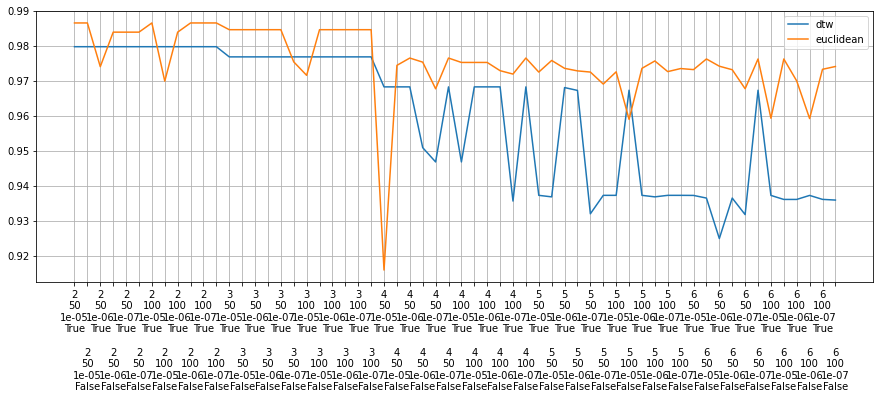

In [295]:
plot_results(results_german)

In [253]:
# Save results
# Creating folder if non existent
folder = 'MATH_GERMAN_split/'
path = DATA_DIR + 'processed/'+folder

if folder.split('/')[0] not in os.listdir(DATA_DIR + 'processed/'):
    os.mkdir(path)
    
# Saving data
filename = 'KMeans_experiments_GERMAN.pickle'
_check = input(f'Are you sure that you want to save {filename} in {path}?\n[yes|no]')
if _check == "yes":
    with open(path + filename, "wb") as f:
        pickle.dump(results_german, f)

Are you sure that you want to save KMeans_experiments_GERMAN.pickle in ../../data/processed/MATH_GERMAN_split/?
[yes|no] yes


In [300]:
# Load results
folder = 'MATH_GERMAN_split/'
path = DATA_DIR + 'processed/'+folder
filename = 'KMeans_experiments_GERMAN.pickle'

with open(path + filename, "rb") as f:
        results_german = pickle.load(f)

In [302]:
# free up memory
del results_german
del results_math

#### KernelKMeans

Model parameters to grid-search:
- `n_clusters`: number of clusters,
- `kernel`: kernel used to apply kernel trick,

In [251]:
# Safekeep 
_check = input("!!! We paused you here in case you are reexecuting the whole notebook. Are you certain that you want to run the next cell again?\n(Your answer does not matter. Please stop the execution now if you do not want the next cell to run.)")

!!! We paused you here in case you are reexecuting the whole notebook. Are you certain that you want to run the next cell again?
(Your answer does not matter. Please stop the execution now if you do not want the next cell to run.) okok


In [259]:
params = {
    'n_clusters':[2, 3, 4],
    'kernel':['gak', 'linear', 'poly', 'sigmoid']
}

print("Runnning German...")
results_german = gridsearch_clustering(KernelKMeans, params, time_series_dataset_german)
print("\nRunning Math...")
results_math = gridsearch_clustering(KernelKMeans, params, time_series_dataset_math)

Runnning German...
Performing 12 iterations in total.


  0%|                                                                           | 0/12 [00:00<?, ?it/s]

Running {'n_clusters': 2, 'kernel': 'gak'}


  8%|█████▎                                                          | 1/12 [14:03<2:34:43, 843.97s/it]

Score: -0.0013027825164103155
Running {'n_clusters': 2, 'kernel': 'linear'}


 17%|██████████▋                                                     | 2/12 [17:34<1:18:35, 471.55s/it]

Score: 0.025378857522340457
Running {'n_clusters': 2, 'kernel': 'poly'}


 25%|████████████████▌                                                 | 3/12 [21:46<55:40, 371.20s/it]

Score: 0.0022763185027867383
Running {'n_clusters': 2, 'kernel': 'sigmoid'}


 33%|██████████████████████                                            | 4/12 [26:05<43:35, 326.99s/it]

Score: -0.034648431181547354
Running {'n_clusters': 3, 'kernel': 'gak'}


 42%|███████████████████████████▌                                      | 5/12 [34:29<45:33, 390.57s/it]

Score: -0.23358335551781542
Running {'n_clusters': 3, 'kernel': 'linear'}


 50%|█████████████████████████████████                                 | 6/12 [37:50<32:37, 326.28s/it]

Score: -0.1956853802715415
Running {'n_clusters': 3, 'kernel': 'poly'}


 58%|██████████████████████████████████████▌                           | 7/12 [41:14<23:51, 286.21s/it]

Score: -0.06050715542715414
Running {'n_clusters': 3, 'kernel': 'sigmoid'}


 67%|████████████████████████████████████████████                      | 8/12 [44:30<17:09, 257.48s/it]

Score: -0.07057777004136194
Running {'n_clusters': 4, 'kernel': 'gak'}


 75%|█████████████████████████████████████████████████▌                | 9/12 [51:58<15:51, 317.06s/it]

Score: -0.1552783429376966
Running {'n_clusters': 4, 'kernel': 'linear'}


 83%|██████████████████████████████████████████████████████▏          | 10/12 [55:09<09:16, 278.33s/it]

Score: -0.10189288972297102
Running {'n_clusters': 4, 'kernel': 'poly'}


 92%|███████████████████████████████████████████████████████████▌     | 11/12 [58:22<04:12, 252.05s/it]

Score: -0.23346163793042515
Running {'n_clusters': 4, 'kernel': 'sigmoid'}


100%|███████████████████████████████████████████████████████████████| 12/12 [1:01:34<00:00, 307.90s/it]


Score: -0.21583182866309736

Running Math...
Performing 12 iterations in total.


  0%|                                                                           | 0/12 [00:00<?, ?it/s]

Running {'n_clusters': 2, 'kernel': 'gak'}


  8%|█████                                                       | 1/12 [1:47:58<19:47:44, 6478.58s/it]

Score: -0.0016749457814779507
Running {'n_clusters': 2, 'kernel': 'linear'}


 17%|██████████                                                  | 2/12 [2:27:15<11:15:43, 4054.32s/it]

Score: -0.002929844177379404
Running {'n_clusters': 2, 'kernel': 'poly'}


 25%|███████████████▎                                             | 3/12 [3:06:54<8:13:21, 3289.03s/it]

Score: 0.0009378230642036003
Running {'n_clusters': 2, 'kernel': 'sigmoid'}


 33%|████████████████████▎                                        | 4/12 [3:39:57<6:09:48, 2773.58s/it]

Score: 0.13206496729852124
Running {'n_clusters': 3, 'kernel': 'gak'}


 42%|█████████████████████████▍                                   | 5/12 [4:45:52<6:13:15, 3199.39s/it]

Score: -0.13258242126511408
Running {'n_clusters': 3, 'kernel': 'linear'}


 50%|██████████████████████████████▌                              | 6/12 [5:11:51<4:24:10, 2641.82s/it]

Score: -0.04832047797159122
Running {'n_clusters': 3, 'kernel': 'poly'}


 58%|███████████████████████████████████▌                         | 7/12 [5:37:13<3:09:38, 2275.78s/it]

Score: -0.18379394817161593
Running {'n_clusters': 3, 'kernel': 'sigmoid'}


 67%|████████████████████████████████████████▋                    | 8/12 [6:03:46<2:17:12, 2058.20s/it]

Score: -0.08957777610035977
Running {'n_clusters': 4, 'kernel': 'gak'}


 75%|█████████████████████████████████████████████▊               | 9/12 [7:02:07<2:05:28, 2509.37s/it]

Score: -0.1563354252114245
Running {'n_clusters': 4, 'kernel': 'linear'}


 83%|█████████████████████████████████████████████████▏         | 10/12 [10:20:46<3:00:28, 5414.21s/it]

Score: -0.17940835139766365
Running {'n_clusters': 4, 'kernel': 'poly'}


 92%|██████████████████████████████████████████████████████     | 11/12 [11:29:06<1:23:32, 5012.10s/it]

Score: -0.12000533320787618
Running {'n_clusters': 4, 'kernel': 'sigmoid'}


100%|█████████████████████████████████████████████████████████████| 12/12 [13:43:21<00:00, 4116.81s/it]

Score: -0.13023582897382294


<span style='color:red'>**Note**</span>

Due to time limitations linked to the clustering using the GAK kernel, we could not run the tests with the german split. Therefore we draw our conclusions from the fully computed (~13 hours) math split experiments.

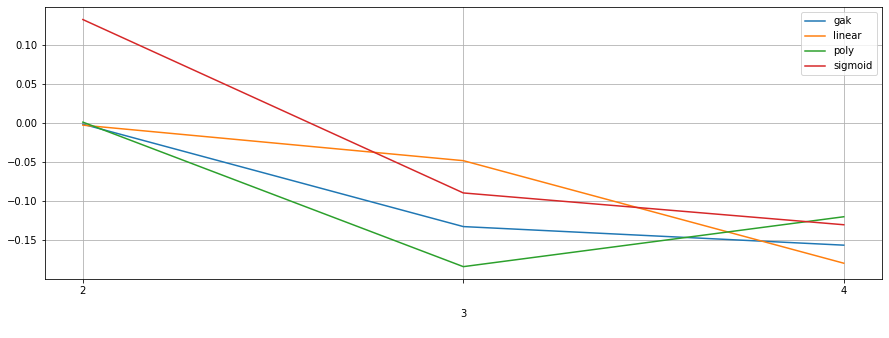

In [281]:
plot_results(results_math, hue='kernel')

In [279]:
# Save results
# Creating folder if non existent
folder = 'MATH_GERMAN_split/'
path = DATA_DIR + 'processed/'+folder

if folder.split('/')[0] not in os.listdir(DATA_DIR + 'processed/'):
    os.mkdir(path)
    
# Saving data
filename = 'KernelKMeans_experiments_MATH.pickle'
_check = input(f'Are you sure that you want to save {filename} in {path}?\n[yes|no]')
if _check == "yes":
    with open(path + filename, "wb") as f:
        pickle.dump(results_math, f)

Are you sure that you want to save KernelKMeans_experiments_MATH.pickle in ../../data/processed/MATH_GERMAN_split/?
[yes|no] yes


In [301]:
# Load results
folder = 'MATH_GERMAN_split/'
path = DATA_DIR + 'processed/'+folder
filename = 'KernelKMeans_experiments_MATH.pickle'

with open(path + filename, "rb") as f:
        results_math = pickle.load(f)

In [282]:
# free up memory
del results_german
del results_math

#### Optimal Clustering

The `KernelKMeans` clustering technique did not seem to yield good results. We observed that the silhouette scores for most configurations averaged out to 0. This can be interpreted as the cluster's centers do not qualify the data with any additional information.

Therefore, we take the best parameter configuration from the `TimeSeriesKMeans` clustering. As discussed before, this configuration is chosen among the tests on the German dataset only as time constrained us in our experiments. We consider that the configuration will cluster the Math dataset in an sufficiently good fashion.

In [283]:
# Load results
folder = 'MATH_GERMAN_split/'
path = DATA_DIR + 'processed/'+folder
filename = 'KMeans_experiments_GERMAN.pickle'

with open(path + filename, "rb") as f:
        results_german = pickle.load(f)

In [284]:
# Extract optimal configuration
optimal = sorted(results_german, key=lambda x : x[1], reverse=True)[0]
print(f'The optimal parameter configuration is the following:\n[TimeSeriesKMeans] {optimal[0]}')
print(f'Silhouette score: {optimal[1]}')

The optimal parameter configuration is the following:
[TimeSeriesKMeans] {'n_clusters': 2, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}
Silhouette score: 0.986604170775415


In [303]:
# Running the clustering for the optimal config
optimal_params = optimal[0]
print(optimal_params)
model = TimeSeriesKMeans(**optimal_params)

labels_german = model.fit_predict(time_series_dataset_german)
labels_math = model.fit_predict(time_series_dataset_math)

print(f"First 5 german cluster labels (total:{len(labels_german)}):\n{labels_german[:5]}")
print()
print(f"First 5 math cluster labels (total:{len(labels_math)}):\n{labels_math[:5]}")

{'n_clusters': 2, 'max_iter': 50, 'tol': 1e-05, 'metric': 'euclidean', 'dtw_inertia': True}
First 5 german cluster labels (total:1374):
[0 0 0 0 0]

First 5 math cluster labels (total:2124):
[0 0 0 0 0]


In [304]:
# Concatenate the labels to the users
users_german = [u for u, _ in time_series_german]
users_math = [u for u, _ in time_series_math]

assert(len(users_german) == len(labels_german)), "Some users were not clustered in the German dataset."
assert(len(users_math) == len(labels_math)), "Some users were not clustered in the Math dataset."

df_labels_german = pd.DataFrame(zip(users_german, labels_german), columns=['user_id', 'cluster_id'])
df_labels_math = pd.DataFrame(zip(users_math, labels_math), columns=['user_id', 'cluster_id'])

df_labels_german.head(3)

,user_id,cluster_id
0,387604.0,0
1,387885.0,0
2,387892.0,0


In [305]:
# Save the data
path = DATA_DIR + 'processed/MATH_GERMAN_split/'

filename = 'clustering_labels_german.pickle'
_check = input(f"Are you certain that you want to save {filename} in {path}?\n[yes|no]")
if _check == 'yes':
    df_labels_german.to_pickle(path+filename)
    
filename = 'clustering_labels_math.pickle'
_check = input(f"Are you certain that you want to save {filename} in {path}?\n[yes|no]")
if _check == 'yes':
    df_labels_math.to_pickle(path+filename)

Are you certain that you want to save clustering_labels_german.pickle in ../../data/processed/MATH_GERMAN_split/?
[yes|no] yes
Are you certain that you want to save clustering_labels_math.pickle in ../../data/processed/MATH_GERMAN_split/?
[yes|no] yes


## Model Building

## Model Evaluation

We are classifying the feature vectors according to wether they improved (`1`) or worsened (`0`) their mastery score.